## Overview

When working with optical satellite imagery, we need to ensure the cloudy-pixels are removed from analysis. Most providers supply QA bands detailing locations of cloudy pixels. There are also third-party cloud-masking packages that can be used to locate and mask cloudy pixels.

In this section, we will use the Scene Classification (SCL) band supplied with Sentinel-2 Level-2A images to remove clouds and cloud-shadows from a scene.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray dask jupyter-server-proxy

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import pystac_client
from odc import stac
import xarray as xr
import rioxarray as rxr

In [ ]:
from dask.distributed import Client
client = Client()  # set up local cluster on the machine
client

If you are running this notebook in Colab, you will need to create and use a proxy URL to see the dashboard running on the local server.

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    port_to_expose = 8787  # This is the default port for Dask dashboard
    print(output.eval_js(f'google.colab.kernel.proxyPort({port_to_expose})'))


## Get a Sentinel-2 Scene

We define a location and time of interest to get some satellite imagery.

In [ ]:
latitude = 27.163
longitude = 82.608
year = 2023

In [ ]:
# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

Search the catalog for matching items. This time we use `'direction': 'desc'` in the `sortby` parameter to get results where the first scene has the highest cloud-cover.

In [ ]:
# Query the STAC Catalog
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={
        'eo:cloud_cover': {'lt': 50},
        's2:nodata_pixel_percentage': {'lt': 10}},
    sortby=[
        {'field': 'properties.eo:cloud_cover',
         'direction': 'desc'}
        ]

)
items = search.item_collection()

# Load to XArray
ds = stac.load(
    items,
    bands=['red', 'green', 'blue', 'scl'],
    resolution=10,
    chunks={},  # <-- use Dask
    groupby='solar_day',
    preserve_original_order=True
)

# Select the first scene
timestamp = pd.to_datetime(items[0].properties['datetime']).tz_convert(None)
scene = ds.sel(time=timestamp)
# Mask nodata values
scene = scene.where(scene != 0)
# Apply scale/offset
scale = 0.0001
offset = -0.1
# Select spectral bands (all except 'scl')
data_bands = [band for band in scene.data_vars if band != 'scl']
for band in data_bands:
  scene[band] = scene[band] * scale + offset

## Visualize the Scene

The clouds will have a much higher reflectance, so `robust=True` will not give us appropriate visualization. We supply hardcoded min/max values as 0 and 0.3 which is the normal range of reflectance values of earth targets.

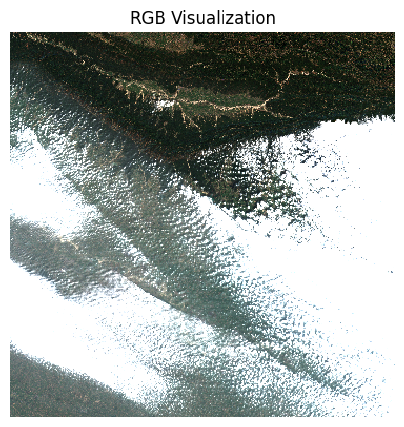

In [15]:
scene_da = scene.to_array('band')

preview = scene_da.rio.reproject(
    scene_da.rio.crs, resolution=300
)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
preview.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    vmin=0, vmax=0.3)
ax.set_title('RGB Visualization')
ax.set_axis_off()
ax.set_aspect('equal')
plt.show()

## Create a Cloud Mask

The Scene Classification (SCL) band has each pixel classified into one of the following classes.

| Value | Description                                 |
|-------|---------------------------------------------|
| 0     | No Data                                     |
| 1     | Saturated or defective pixel                |
| 2     | Dark area pixels                            |
| 3     | Cloud shadows                               |
| 4     | Vegetation                                  |
| 5     | Not vegetated                               |
| 6     | Water                                       |
| 7     | Clouds Low Probability / Unclassified                                |
| 8     | Cloud medium probability                    |
| 9     | Cloud high probability                      |
| 10    | Thin cirrus                                 |
| 11    | Snow / Ice                                  |

We select the types of pixels we want to mask. Let's create a mask that will remove all pixels marked `Cloud shadows (3)`, `Cloud Medium Probability (8)`, `Cloud High Probability (9)` and `Thin Cirrus (10)`.

In [ ]:
mask = scene.scl.isin([3,8,9,10])

Visualize the mask by overlaying it on the scene.

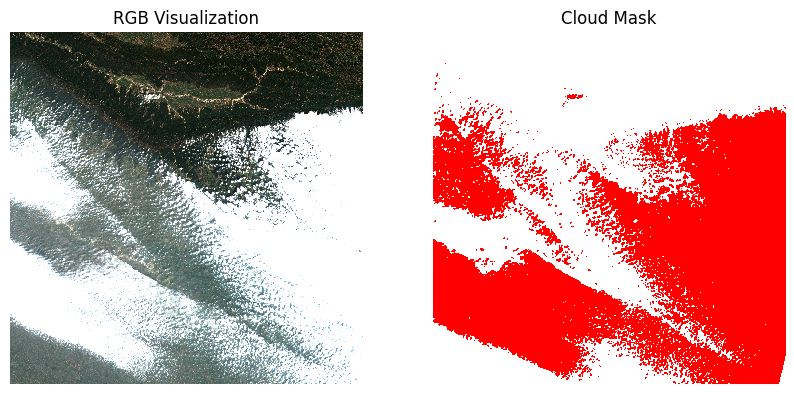

In [14]:
mask_preview = mask.astype('uint8').rio.reproject(
    mask.rio.crs, resolution=300
)

fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_size_inches(10,5)
preview.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax0,
    vmin=0, vmax=0.3)
ax0.set_title('RGB Visualization')

# RGBA: Transparent, Red
mask_colormap = ListedColormap(['#00000000', '#FF0000FF'])
mask_preview.plot.imshow(
    ax=ax1,
    cmap=mask_colormap,
    add_colorbar=False)

ax1.set_title('Cloud Mask')
for ax in (ax0, ax1):
  ax.set_axis_off()
  ax.set_aspect('equal')
plt.show()

Once we are satisfied that the mask looks good, we go ahead and apply the mask on the scene.

In [ ]:
# Apply the mask to all the data bands
scene_masked = scene[data_bands].where(~mask)
scene_masked

## Exercise

Save the masked scene to disk. The code snippet below mounts your Google Drive and creates a `data` folder. Save the `scene_masked` to the data folder.

Hint: You will need to convert the `scene_masked` to a DataArray before saving it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive_folder_root = 'MyDrive'
output_folder = 'data'
output_folder_path = os.path.join(
    '/content/drive', drive_folder_root, output_folder)

# Check if Google Drive is mounted
if not os.path.exists('/content/drive'):
    print("Google Drive is not mounted. Please run the cell above to mount your drive.")
else:
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)